## Table of Contents
01. Importing libraries and data
    <br>I.	Import libraries
    <br>II.	Import data
02. Security implications: PII data
03. Customer behavior in different geographic areas
	<br>I. Percentage of high/low spenders by region
    <br>II. Descriptive statistics
04. Exclusion flag for low-activity customers
05. Customer profiling
    <br>I. Create a column for the department name based on 'department_id'
    <br>II. Identify the department generating the highest revenue
	<br>III. Create a profiling variable based on age, income, number of dependants and whether produce has been purchased
06. Create an appropriate visualization to show the distribution of profiles
    <br>I. Number of users by customer profile
    <br>II. Number of orders by customer profile
07. Aggregate the max, mean, and min variables on a customer-profile level
    <br>I. Usage frequency
    <br>II. Expenditure
08. Compare your customer profiles with regions and departments
    <br>I. Northeast
	<br>II. Midwest
	<br>III. South
    <br>IV. West
09. Business questions
    <br>I. What are the busiest days of the week and hours of the day in terms of orders?
    <br>II. When do people spend the most money throughout the day?
    <br>III. Create simpler price range groupings
    <br>IV. Are there certain types of products that are more popular than others in terms of frequency of orders?
    <br>V. What’s the distribution among users in regards to their brand loyalty?
    <br>VI. Are there differences in ordering habits based on a customer’s loyalty status?
    <br>VII. Are there differences in ordering habits based on a customer’s region?
    <br>VIII. Is there a connection between age and family status in terms of ordering habits?
    <br>IX. What different classifications does the demographic information suggest?
    <br>X. What differences can you find in ordering habits of different customer profiles?

# 01. Importing libraries and data

## I. Import libraries

In [1]:
# Import libraries
import warnings
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

from pandas.core.common import SettingWithCopyWarning
from scipy.stats import norm

## II. Import data

In [2]:
# Import data from 'orders_products_customers_merged.pkl'
warnings.simplefilter(action='ignore', category=FutureWarning) # Added to ignore warnings
path = r'C:\Users\lucav\Desktop\Instacart Basket Analysis'
df = pd.read_pickle(os.path.join(path, '02 Data','Prepared Data', 'orders_products_customers_final.pkl'))

# 02. Security implications: PII data

In [3]:
# Inspect the columns within 'df'
df.columns

Index(['order_id', 'user_id', 'order_number', 'day_of_week', 'hour_of_day',
       'days_since_prior_order', 'first_order', 'product_id',
       'add_to_cart_order', 'reordered', 'product_name', 'aisle_id',
       'department_id', 'prices', 'price_range_loc', 'busiest_days',
       'busiest_period_of_day', 'max_order', 'loyalty_flag',
       'customer_spending', 'spending_flag', 'order_frequency',
       'order_frequency_flag', 'first_name', 'last_name', 'gender', 'state',
       'age', 'date_joined', 'n_dependants', 'fam_status', 'income'],
      dtype='object')

The data contains the "first_name" and "last_name" columns that are deemed to be personally identifiable information (PII). Hence, those columns will be removed.

In [4]:
# Drop the 'first_name' and 'last_name' columns
df.drop(['first_name', 'last_name'], axis = 1, inplace = True)

# 03. Customer behavior in different geographic areas

In [5]:
# Define regions
Northeast = ['Maine','New Hampshire','Vermont','Massachusetts','Rhode Island','Connecticut','New York','Pennsylvania','New Jersey']
Midwest = ['Wisconsin','Michigan','Illinois','Indiana','Ohio','North Dakota','South Dakota','Nebraska','Kansas','Minnesota',
           'Iowa','Missouri']
South = ['Delaware','Maryland','District of Columbia','Virginia','West Virginia','North Carolina','South Carolina'
       ,'Georgia','Florida','Kentucky','Tennessee','Mississippi','Alabama','Oklahoma','Texas','Arkansas','Louisiana']
West = ['Idaho','Montana','Wyoming','Nevada','Utah','Colorado','Arizona','New Mexico','Alaska','Washington','Oregon','California',
        'Hawaii']

In [6]:
# Based on the 'state' column, return the corresponding region and store the result in the 'region' list

region = []

for value in df['state']:
    if value in Northeast:
        region.append('Northeast')
    elif value in Midwest:
        region.append('Midwest')
    elif value in South:
        region.append('South')
    elif value in West:
        region.append('West')

In [7]:
# Add 'region' list to the dataframe as a column
df['region'] = region

## I. Percentage of high/low spenders by region

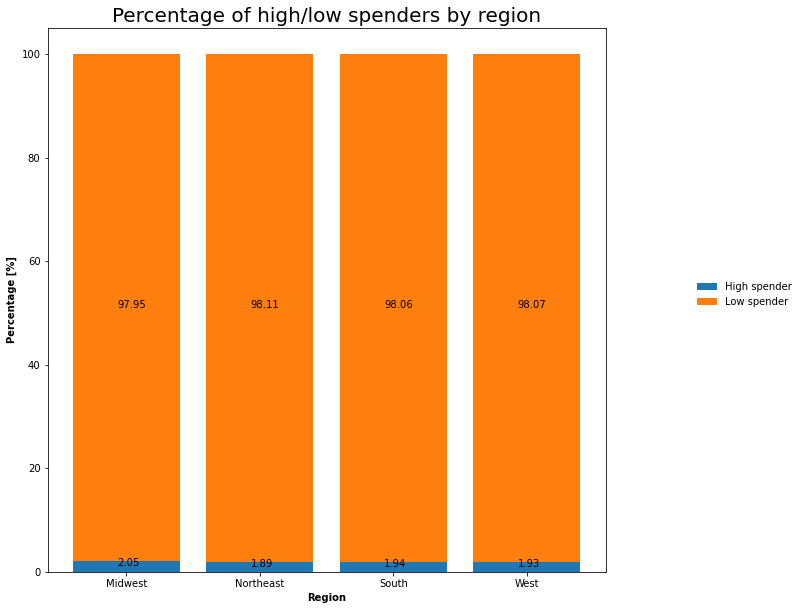

In [8]:
# Plot a stacked bar chart to visualize how the percentage of high and low spenders changes by region

# Create a crosstab between the 'region' and 'spending_flag' columns
region_spending = pd.crosstab(index = df['region'], columns = df['spending_flag'], normalize="index")

# Create plot
fig, ax = plt.subplots(figsize=(10,10))

# Initialise the bottom of the first set of bars at 0
bottom = np.zeros(len(region_spending))

# Plot each bar
for i, col in enumerate(region_spending.columns):
    ax.bar(region_spending.index, region_spending[col]*100, bottom=bottom, label=col)
    bottom += np.array(region_spending[col]*100)

# Plot label inside each column
y_offset = 0
x_offset = -0.07
for bar in ax.patches:
    ax.text(bar.get_x() + bar.get_width() / 2 + x_offset, bar.get_height() / 2 + bar.get_y() + y_offset,
            round(bar.get_height(),2))

plt.legend(bbox_to_anchor = (1.35,0.55), frameon = False)
plt.ylabel("Percentage [%]")
plt.xlabel("Region")
plt.title("Percentage of high/low spenders by region", size=20)

plt.show()

As it can be observed in the chart, the percentage of high and low spenders (threshold of $10) is consistent throughout the different regions.

In [9]:
# Export chart as image (.png)
fig.savefig(os.path.join(path, '04 Analysis','Visualizations', 'stacked_spending_region.png'))

## II. Descriptive statistics

In [10]:
# Compute the mean, min and max of the 'prices' column for each region
df.groupby('region').agg({'prices': ['mean', 'min', 'max']})

prices           
               mean  min   max
region                        
Midwest    7.792584  1.0  25.0
Northeast  7.782409  1.0  25.0
South      7.794918  1.0  25.0
West       7.790355  1.0  25.0

The table shows that the average amount spent is consistent throughout the different regions.

# 04. Exclusion flag for low-activity customers

In [11]:
# Create a flag based on the number of orders
df.loc[df['max_order'] >= 5, 'activity_flag'] = 'High activity'
df.loc[df['max_order'] < 5, 'activity_flag'] = 'Low activity'

In [12]:
# Exclude rows where 'activity_flag' corresponds to 'Low activity'
df = df.loc[df['activity_flag'] == 'High activity']

In [13]:
# Export 'df' as 'df_high_activity.pkl'
df.to_pickle(os.path.join(path,'02 Data','Prepared Data','df_high_activity.pkl'))

# 05. Customer profiling

## I. Create a column for the department name based on 'department_id'

In [2]:
# Import data from 'df_high_activity.pkl'
path = r'C:\Users\lucav\Desktop\Instacart Basket Analysis'
df = pd.read_pickle(os.path.join(path, '02 Data','Prepared Data', 'df_high_activity.pkl'))

In [15]:
# Import data from 'departments.csv'
depts = pd.read_csv(os.path.join(path, '02 Data','Original Data', 'departments.csv'))

In [16]:
# Create a data dictionary from 'depts'

# Transpose the original 'depts'
depts = depts.T
# Store the header
new_header = depts.iloc[0]
# Exclude the first row
depts = depts[1:]
# Set new_header as header
depts.columns = new_header
# Create data dictionary
depts_dict = depts.to_dict('index')

In [17]:
# Create a 'department' column to store the department name
for i in depts_dict:
    df.loc[df['department_id'] == int(i), 'department'] = depts_dict[str(i)]['department']

## II. Identify the department generating the highest revenue

In [18]:
# Compute the total revenue by department
revenue_by_dept = df.groupby('department').agg({'prices': ['sum']})

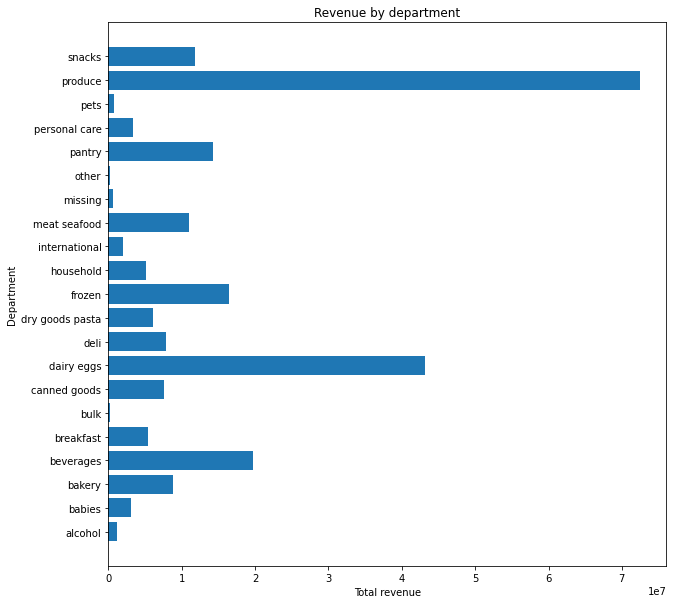

In [19]:
# Plot a bar chart to display the revenue by department
y = revenue_by_dept['prices']['sum'].index
x = revenue_by_dept['prices']['sum']

plt.figure(figsize=(10,10))
plt.title('Revenue by department')
plt.barh(y, x)
plt.ylabel('Department')
plt.xlabel('Total revenue [$]')

# Export chart as image (.png)
plt.savefig(os.path.join(path, '04 Analysis','Visualizations', 'bar_revenue_department.png'))
plt.show()

It can be observed that the "produce" department generates the highest revenue. Hence, the profiling variable will include whether a customer is a produce consumer.

## III. Create a profiling variable based on age, income, number of dependants and whether produce has been purchased

The age ranges are the following:
- 18 to 34 years old: Young adult
- 35 to 64 years old: Adult
- over 65 years old: Senior

Source: https://www.census.gov/library/publications/2017/demo/p20-579.html
<br>Source: https://acl.gov/sites/default/files/Aging%20and%20Disability%20in%20America/2020ProfileOlderAmericans.Final_.pdf

The income ranges are the following:
- less than \\$52200: Low income
- between \\$52201 and \\$156599: Middle income
- more than \\$156600: Upper income

Source: https://money.usnews.com/money/personal-finance/family-finance/articles/where-do-i-fall-in-the-american-economic-class-system

In [20]:
# Import data from 'customers.csv'
path = r'C:\Users\lucav\Desktop\Instacart Basket Analysis'
df_customers = pd.read_pickle(os.path.join(path, '02 Data','Prepared Data', 'customers_prepared.pkl'))

In [21]:
# Inspect the columns within 'df_customers'
df_customers.columns

Index(['user_id', 'first_name', 'last_name', 'gender', 'state', 'age',
       'date_joined', 'n_dependants', 'fam_status', 'income'],
      dtype='object')

In [22]:
# Drop the 'first_name' and 'last_name' columns
df_customers.drop(['first_name', 'last_name'], axis = 1, inplace = True)

In [23]:
# Create the 'customer_profile' column and add information about age range
df_customers.loc[(df_customers['age'] >= 18) & (df_customers['age'] <= 34), 'customer_profile'] = 'Young adult'
df_customers.loc[(df_customers['age'] >= 35) & (df_customers['age'] <= 64), 'customer_profile'] = 'Adult'
df_customers.loc[df_customers['age'] >= 65, 'customer_profile'] = 'Senior'

In [24]:
# Add information about number of dependants
df_customers.loc[df_customers['n_dependants'] == 0, 'customer_profile'] = df_customers['customer_profile'] + ', No kids'
df_customers.loc[df_customers['n_dependants'] > 0, 'customer_profile'] = df_customers['customer_profile'] + ', With kids'

In [25]:
# Add information about income
df_customers.loc[df_customers['income'] <= 52200, 'customer_profile'] = df_customers['customer_profile'] + ', Low income'
df_customers.loc[(df_customers['income'] > 52200) & (df_customers['income'] < 156600), 'customer_profile'] = df_customers['customer_profile'] + ', Middle income'
df_customers.loc[df_customers['income'] >= 156600, 'customer_profile'] = df_customers['customer_profile'] + ', Upper income'

In [27]:
# Keep only the 'user_id' and 'customer_profile' columns
df_customers.drop(['gender', 'state', 'age', 'date_joined', 'n_dependants', 'fam_status', 'income'], axis = 1, inplace = True)

In [29]:
# Identify customers that are 'produce' consumers
produce_consumer = df.loc[df['department'] == 'produce']

In [30]:
# Create a list containing the user ids of customers that are 'produce' consumers
produce_consumer = produce_consumer['user_id'].unique().tolist()

In [31]:
# Create a list containing information about whether a customer is a 'produce' consumer based on user ids
from tqdm import tqdm
result = []

for item in tqdm(df_customers['user_id']):
    if item in produce_consumer:
        result.append('Produce consumer')
    else:
        result.append('Not a Produce consumer')

100%|██████████| 206209/206209 [29:12<00:00, 117.67it/s]


In [38]:
# Add information to the 'customer_profile' about whether a customer is a 'produce' consumer
df_customers['customer_profile'] = df_customers['customer_profile'] + ', ' + result

In [40]:
# Export 'df_customers' as 'df_customer_profile.pkl'
df_customers.to_pickle(os.path.join(path,'02 Data','Prepared Data','df_customer_profile.pkl'))

In [43]:
# Check that the data type of 'user_id' is the same in 'df_customer' and 'df'
df_customers['user_id'].dtype == df['user_id'].dtype

True

In [44]:
# Merge 'df_customers' with 'df' using 'user_id' as key column
df_ords_prods_profile = df.merge(df_customers, on = 'user_id')

In [48]:
# Export 'df_ords_prods_profile' as 'orders_products_profiles.pkl'
df_ords_prods_profile.to_pickle(os.path.join(path,'02 Data','Prepared Data','orders_products_profiles.pkl'))

# 06. Create an appropriate visualization to show the distribution of profiles

In [ ]:
# Import data from 'orders_products_profiles.pkl' and 'df_customer_profile.pkl'
path = r'C:\Users\lucav\Desktop\Instacart Basket Analysis'
df_ords_prods_profile = pd.read_pickle(os.path.join(path, '02 Data','Prepared Data', 'orders_products_profiles.pkl'))
df_customers = pd.read_pickle(os.path.join(path, '02 Data','Prepared Data', 'df_customer_profile.pkl'))

## I. Number of users by customer profile

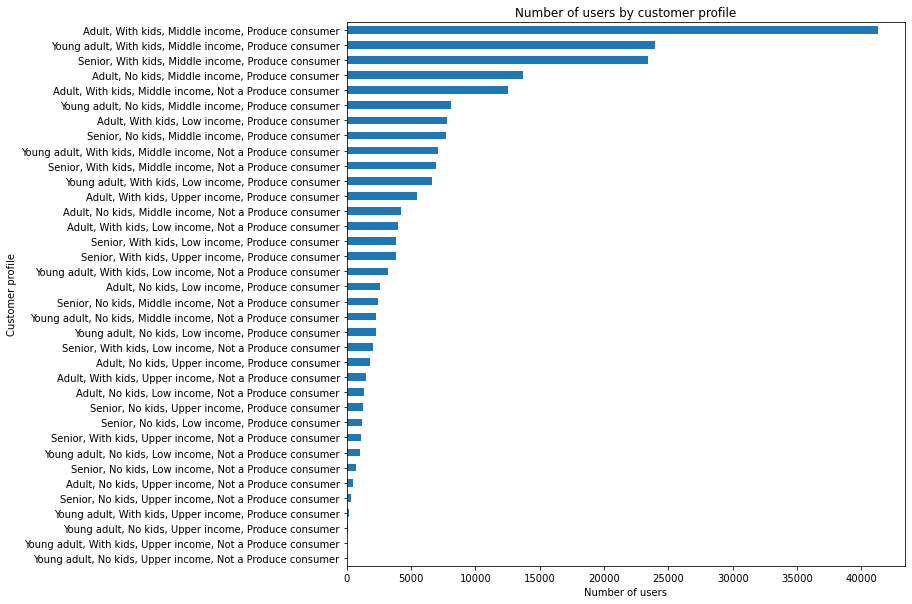

In [3]:
# Plot a bar chart to display the number of users for each customer profile
plt.figure(figsize=(10,10))
plt.title('Number of users by customer profile')
df_customers['customer_profile'].value_counts().sort_values().plot.barh()
plt.ylabel('Customer profile')
plt.xlabel('Number of users')

# Export chart as image (.png)
plt.savefig(os.path.join(path, '04 Analysis','Visualizations', 'bar_users_profiles.png'))
plt.show()

It can be observed that the most represented customer profile is "**Adult, With kids, Middle income, Produce consumer**" with over 40000 users.

## II. Number of orders by customer profile

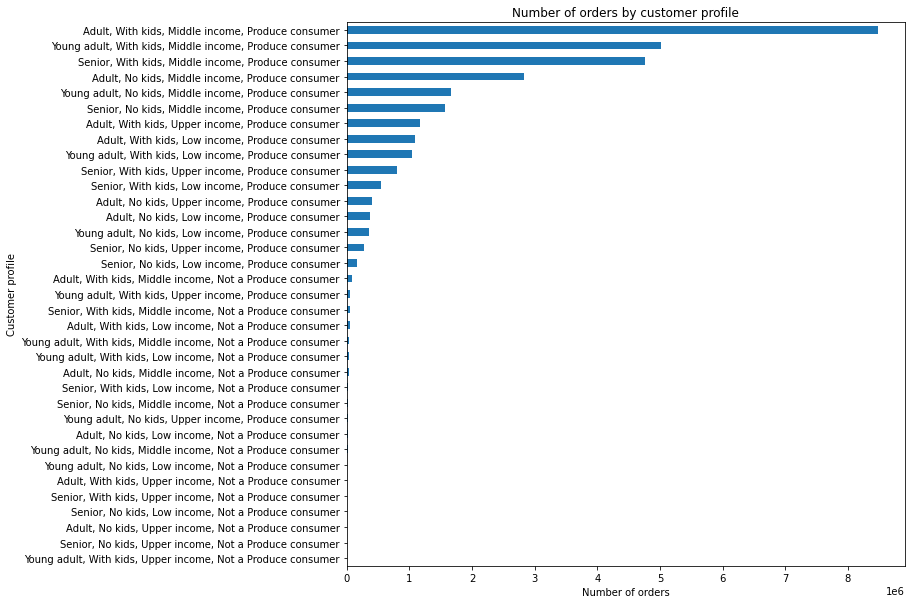

In [4]:
# Plot a bar chart to display the number of orders placed by each customer profile
plt.figure(figsize=(10,10))
plt.title('Number of orders by customer profile')
df_ords_prods_profile['customer_profile'].value_counts().sort_values().plot.barh()
plt.ylabel('Customer profile')
plt.xlabel('Number of orders')

# Export chart as image (.png)
plt.savefig(os.path.join(path, '04 Analysis','Visualizations', 'bar_orders_profiles.png'))
plt.show()

It can also be observed that, due to being the most represented, the customer profile "Adult, With kids, Middle income, Produce consumer" is the one placing the largest number of orders.

# 07. Aggregate the max, mean, and min variables on a customer-profile level

## I. Usage frequency

In [5]:
# Compute the mean, min and max of the 'order_frequency' column for each customer profile
df_ords_prods_profile.groupby('customer_profile').agg({'order_frequency': ['mean', 'min', 'max']}).sort_values(('order_frequency','mean'))

order_frequency           
                                                              mean  min   max
customer_profile                                                             
Young adult, With kids, Upper income, Produce c...        8.984521  2.0  30.0
Adult, No kids, Upper income, Produce consumer            9.534044  0.0  30.0
Young adult, No kids, Upper income, Produce con...        9.627504  3.0  30.0
Senior, With kids, Upper income, Produce consumer         9.717983  0.0  30.0
Senior, No kids, Upper income, Produce consumer           9.764492  1.0  30.0
Senior, No kids, Middle income, Produce consumer          9.787069  0.5  30.0
Young adult, With kids, Middle income, Produce ...        9.811564  0.0  30.0
Adult, With kids, Upper income, Produce consumer          9.836464  0.0  30.0
Adult, No kids, Middle income, Produce consumer           9.837524  0.0  30.0
Adult, With kids, Middle income, Produce consumer         9.884506  0.0  30.0
Senior, With kids, Middle income, Produce consumer        9.894301  0.0  30.0
Young adult, No kids, Middle income, Produce co...        9.949704  0.0  30.0
Senior, With kids, Low income, Produce consumer          10.144157  0.0  30.0
Young adult, No kids, Low income, Produce consumer       10.208984  0.0  30.0
Adult, No kids, Low income, Produce consumer             10.241763  0.0  30.0
Young adult, With kids, Low income, Produce con...       10.296213  0.0  30.0
Senior, No kids, Low income, Produce consumer            10.371602  0.0  30.0
Adult, With kids, Low income, Produce consumer           10.538066  0.0  30.0
Young adult, With kids, Upper income, Not a Pro...       11.239203  5.0  17.0
Adult, No kids, Upper income, Not a Produce con...       13.243019  1.0  30.0
Adult, With kids, Middle income, Not a Produce ...       13.328036  0.0  30.0
Young adult, With kids, Low income, Not a Produ...       13.394741  0.0  30.0
Adult, With kids, Upper income, Not a Produce c...       13.498954  1.0  30.0
Adult, No kids, Middle income, Not a Produce co...       13.552902  0.0  30.0
Senior, With kids, Middle income, Not a Produce...       13.561577  0.0  30.0
Senior, No kids, Upper income, Not a Produce co...       13.620020  4.0  30.0
Young adult, With kids, Middle income, Not a Pr...       13.747417  0.0  30.0
Young adult, No kids, Low income, Not a Produce...       13.778175  0.0  30.0
Senior, No kids, Middle income, Not a Produce c...       13.848895  1.0  30.0
Senior, With kids, Upper income, Not a Produce ...       13.963054  1.0  30.0
Adult, With kids, Low income, Not a Produce con...       14.320981  0.0  30.0
Adult, No kids, Low income, Not a Produce consumer       14.328864  1.0  30.0
Young adult, No kids, Middle income, Not a Prod...       14.574737  0.0  30.0
Senior, No kids, Low income, Not a Produce cons...       14.933915  2.0  30.0
Senior, With kids, Low income, Not a Produce co...       15.208065  1.0  30.0

The table shows that the customer profile "**Young adult, With kids, Upper income, Produce consumer**" is the one placing orders the most frequently, with an average of 9 days between orders. <br>On the opposite, the customer profile "**Senior, With kids, Low income, Not a Produce consumer**" is the one placing orders the least frequently, with an average of over 15 days between orders.

## II. Expenditure

In [6]:
# Compute the mean, min and max of the 'customer_spending' column for each customer profile
df_ords_prods_profile.groupby('customer_profile').agg({'customer_spending': ['mean', 'min', 'max']}).sort_values(('customer_spending','mean'), ascending=False)

customer_spending  \
                                                                mean   
customer_profile                                                       
Young adult, With kids, Upper income, Not a Pro...        403.431561   
Young adult, With kids, Upper income, Produce c...        316.848498   
Young adult, No kids, Upper income, Produce con...        265.652398   
Adult, No kids, Upper income, Not a Produce con...        247.115691   
Senior, With kids, Upper income, Not a Produce ...        157.315184   
Adult, With kids, Upper income, Not a Produce c...         70.274868   
Adult, With kids, Upper income, Produce consumer           35.681680   
Adult, No kids, Upper income, Produce consumer             31.024542   
Senior, No kids, Upper income, Produce consumer            30.184856   
Senior, With kids, Upper income, Produce consumer          28.590489   
Adult, No kids, Middle income, Not a Produce co...         19.871143   
Senior, With kids, Middle income, Not a Produce...         12.177867   
Young adult, No kids, Middle income, Produce co...         10.693771   
Adult, With kids, Middle income, Not a Produce ...         10.109777   
Young adult, With kids, Middle income, Produce ...         10.090505   
Adult, No kids, Middle income, Produce consumer             9.762973   
Senior, No kids, Middle income, Produce consumer            9.498672   
Senior, No kids, Middle income, Not a Produce c...          9.458993   
Adult, With kids, Middle income, Produce consumer           9.230093   
Senior, With kids, Middle income, Produce consumer          9.210256   
Young adult, With kids, Middle income, Not a Pr...          8.575229   
Young adult, No kids, Middle income, Not a Prod...          8.077277   
Senior, No kids, Upper income, Not a Produce co...          8.028287   
Young adult, No kids, Low income, Produce consumer          7.051470   
Young adult, With kids, Low income, Produce con...          7.037915   
Adult, With kids, Low income, Produce consumer              6.686909   
Adult, No kids, Low income, Produce consumer                6.663424   
Senior, No kids, Low income, Produce consumer               6.537105   
Senior, With kids, Low income, Produce consumer             6.526030   
Young adult, No kids, Low income, Not a Produce...          6.281728   
Young adult, With kids, Low income, Not a Produ...          6.256813   
Adult, No kids, Low income, Not a Produce consumer          6.018723   
Senior, With kids, Low income, Not a Produce co...          6.008972   
Adult, With kids, Low income, Not a Produce con...          6.004026   
Senior, No kids, Low income, Not a Produce cons...          5.924160   

                                                                              
                                                           min           max  
customer_profile                                                              
Young adult, With kids, Upper income, Not a Pro...  154.027451   1154.823077  
Young adult, With kids, Upper income, Produce c...   24.579249  10209.987755  
Young adult, No kids, Upper income, Produce con...   26.759379   4174.447917  
Adult, No kids, Upper income, Not a Produce con...    7.066667  15006.940000  
Senior, With kids, Upper income, Not a Produce ...    7.020000   7414.485185  
Adult, With kids, Upper income, Not a Produce c...    7.027778   6390.138298  
Adult, With kids, Upper income, Produce consumer      7.000000   6983.593023  
Adult, No kids, Upper income, Produce consumer        7.002308   6388.812766  
Senior, No kids, Upper income, Produce consumer       7.000575   2673.245778  
Senior, With kids, Upper income, Produce consumer     7.001093   3902.835065  
Adult, No kids, Middle income, Not a Produce co...    2.382759   3453.431034  
Senior, With kids, Middle income, Not a Produce...    3.120000   2410.696774  
Young adult, No kids, Middle income, Produce co...    7.000000   8794.882427  
Adult, With kids, Middle income, Not a Produce ...

The table shows that the customer profile "**Young adult, With kids, Upper income, Not a Produce consumer**" is the one spending the most, with an average of \\$403. <br>On the opposite, the customer profile "**Senior, No kids, Low income, Not a Produce consumer**" is the one spending the least, with an average of less than \\$6.

# 08. Compare your customer profiles with regions and departments

## I. Northeast

In [3]:
# Create a subset for the Northeast region
df_ords_prods_profile_Northeast = df_ords_prods_profile.loc[df_ords_prods_profile['region'] == 'Northeast']

In [48]:
# Identify the top 5 departments by revenue in the Northeast region
top_5_depts = df_ords_prods_profile_Northeast.groupby('department').agg({'prices': ['sum']}).sort_values(('prices','sum'), ascending=False)[:5]

In [123]:
# Identify the top 5 customer profiles by expenditure in the Northeast region
top_5_profiles = df_ords_prods_profile_Northeast.groupby('customer_profile').agg({'customer_spending': ['sum']}).sort_values(('customer_spending','sum'), ascending=False)[:5]

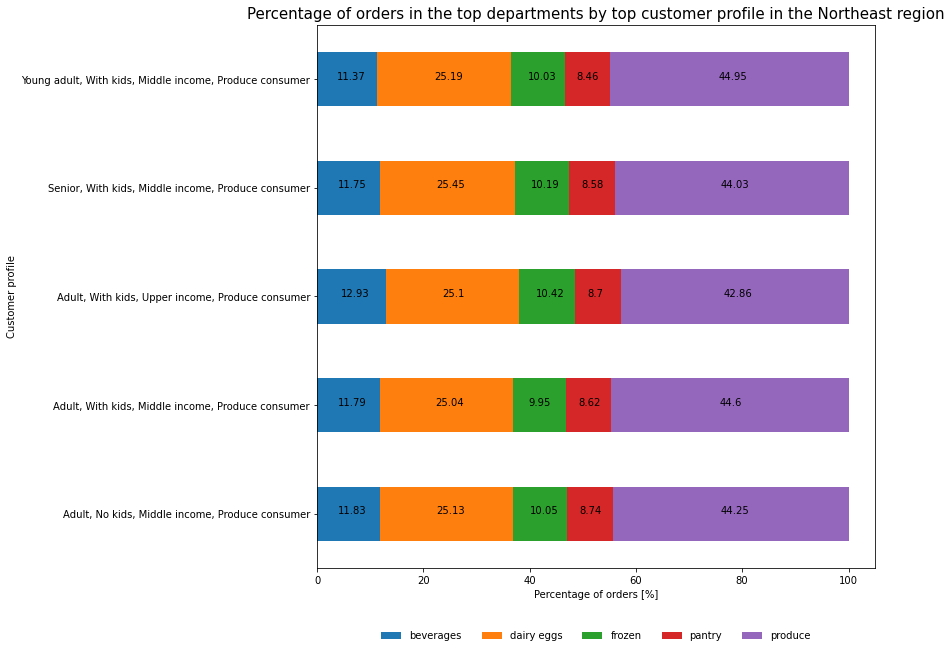

In [146]:
# Plot a stacked bar chart to visualize the number of orders in each of the top 5 departments by top 5 customer profiles

# Create a crosstab between the 'customer_profile' and 'department' columns
profile_department = pd.crosstab(index = df_ords_prods_profile_Northeast['customer_profile'], columns = df_ords_prods_profile_Northeast['department'])

# Keep only the top 5 departments
to_drop_dept = []
for i in list(profile_department.columns):
    if i not in list(top_5_depts['prices'].index):
        to_drop_dept.append(i)

profile_department.drop(to_drop_dept, axis = 1, inplace = True)
profile_department = profile_department.div(profile_department.sum(axis=1), axis=0)*100
        
# Keep only the top 5 profiles
to_drop_profile = []
for i in list(profile_department.index):
    if i not in list(top_5_profiles['customer_spending'].index):
        to_drop_profile.append(i)
        
profile_department.drop(to_drop_profile, axis = 0, inplace = True)

# Create plot
ax = profile_department.plot.barh(stacked=True, figsize=(10, 10))

# Plot label inside each column
y_offset = 0
x_offset = -2
for bar in ax.patches:
    ax.text(bar.get_x() + bar.get_width() / 2 + x_offset, bar.get_height() / 2 + bar.get_y() + y_offset,
            round(bar.get_width(),2))

plt.legend(loc = 'lower center', bbox_to_anchor=(0.5, -0.15), frameon = False, ncol = len(profile_department.columns))
plt.ylabel("Customer profile")
plt.xlabel("Percentage of orders [%]")
plt.title("Percentage of orders in the top departments by top customer profile in the Northeast region", size=15)

# Export chart as image (.png)
plt.savefig(os.path.join(path, '04 Analysis','Visualizations', 'bar_stacked_Northeast_orders_depts_profile.png'))
plt.show()

## II. Midwest

In [3]:
# Create a subset for the Midwest region
df_ords_prods_profile_Midwest = df_ords_prods_profile.loc[df_ords_prods_profile['region'] == 'Midwest']

In [4]:
# Identify the top 5 departments by revenue in the Midwest region
top_5_depts = df_ords_prods_profile_Midwest.groupby('department').agg({'prices': ['sum']}).sort_values(('prices','sum'), ascending=False)[:5]

In [5]:
# Identify the top 5 customer profiles by expenditure in the Midwest region
top_5_profiles = df_ords_prods_profile_Midwest.groupby('customer_profile').agg({'customer_spending': ['sum']}).sort_values(('customer_spending','sum'), ascending=False)[:5]

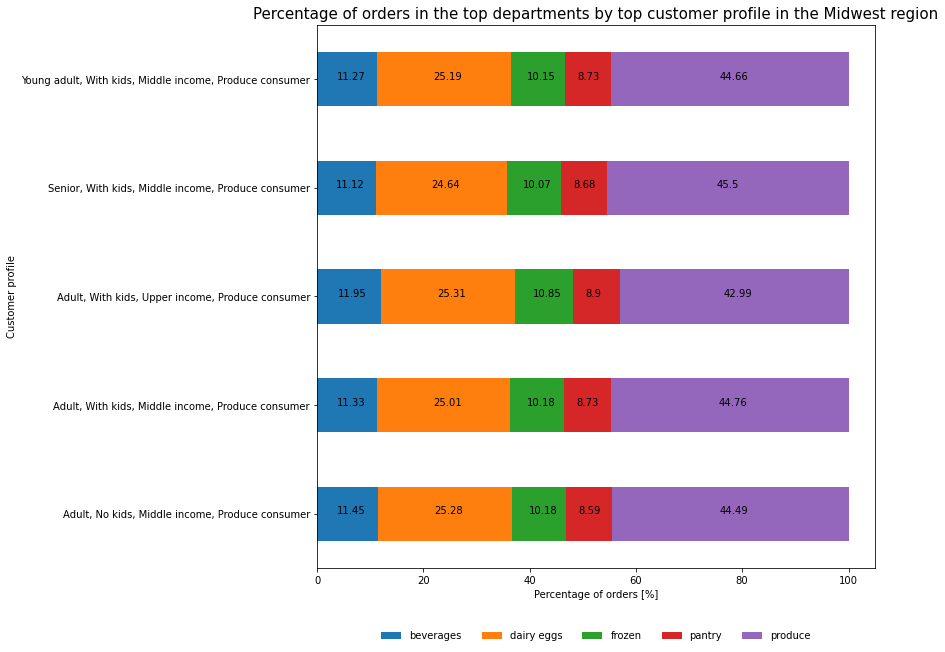

In [6]:
# Plot a stacked bar chart to visualize the number of orders in each of the top 5 departments by top 5 customer profiles

# Create a crosstab between the 'customer_profile' and 'department' columns
profile_department = pd.crosstab(index = df_ords_prods_profile_Midwest['customer_profile'], columns = df_ords_prods_profile_Midwest['department'])

# Keep only the top 5 departments
to_drop_dept = []
for i in list(profile_department.columns):
    if i not in list(top_5_depts['prices'].index):
        to_drop_dept.append(i)

profile_department.drop(to_drop_dept, axis = 1, inplace = True)
profile_department = profile_department.div(profile_department.sum(axis=1), axis=0)*100
        
# Keep only the top 5 profiles
to_drop_profile = []
for i in list(profile_department.index):
    if i not in list(top_5_profiles['customer_spending'].index):
        to_drop_profile.append(i)
        
profile_department.drop(to_drop_profile, axis = 0, inplace = True)

# Create plot
ax = profile_department.plot.barh(stacked=True, figsize=(10, 10))

# Plot label inside each column
y_offset = 0
x_offset = -2
for bar in ax.patches:
    ax.text(bar.get_x() + bar.get_width() / 2 + x_offset, bar.get_height() / 2 + bar.get_y() + y_offset,
            round(bar.get_width(),2))

plt.legend(loc = 'lower center', bbox_to_anchor=(0.5, -0.15), frameon = False, ncol = len(profile_department.columns))
plt.ylabel("Customer profile")
plt.xlabel("Percentage of orders [%]")
plt.title("Percentage of orders in the top departments by top customer profile in the Midwest region", size=15)

# Export chart as image (.png)
plt.savefig(os.path.join(path, '04 Analysis','Visualizations', 'bar_stacked_Midwest_orders_depts_profile.png'))
plt.show()

## III. South

In [3]:
# Create a subset for the South region
df_ords_prods_profile_South = df_ords_prods_profile.loc[df_ords_prods_profile['region'] == 'South']

In [4]:
# Identify the top 5 departments by revenue in the South region
top_5_depts = df_ords_prods_profile_South.groupby('department').agg({'prices': ['sum']}).sort_values(('prices','sum'), ascending=False)[:5]

In [5]:
# Identify the top 5 customer profiles by expenditure in the South region
top_5_profiles = df_ords_prods_profile_South.groupby('customer_profile').agg({'customer_spending': ['sum']}).sort_values(('customer_spending','sum'), ascending=False)[:5]

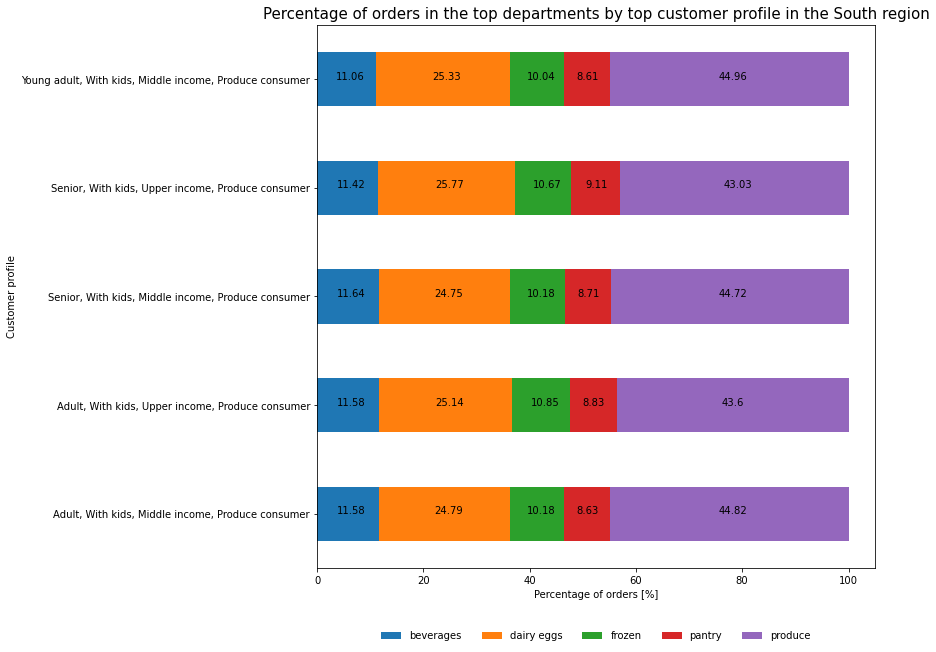

In [6]:
# Plot a stacked bar chart to visualize the number of orders in each of the top 5 departments by top 5 customer profiles

# Create a crosstab between the 'customer_profile' and 'department' columns
profile_department = pd.crosstab(index = df_ords_prods_profile_South['customer_profile'], columns = df_ords_prods_profile_South['department'])

# Keep only the top 5 departments
to_drop_dept = []
for i in list(profile_department.columns):
    if i not in list(top_5_depts['prices'].index):
        to_drop_dept.append(i)

profile_department.drop(to_drop_dept, axis = 1, inplace = True)
profile_department = profile_department.div(profile_department.sum(axis=1), axis=0)*100
        
# Keep only the top 5 profiles
to_drop_profile = []
for i in list(profile_department.index):
    if i not in list(top_5_profiles['customer_spending'].index):
        to_drop_profile.append(i)
        
profile_department.drop(to_drop_profile, axis = 0, inplace = True)

# Create plot
ax = profile_department.plot.barh(stacked=True, figsize=(10, 10))

# Plot label inside each column
y_offset = 0
x_offset = -2
for bar in ax.patches:
    ax.text(bar.get_x() + bar.get_width() / 2 + x_offset, bar.get_height() / 2 + bar.get_y() + y_offset,
            round(bar.get_width(),2))

plt.legend(loc = 'lower center', bbox_to_anchor=(0.5, -0.15), frameon = False, ncol = len(profile_department.columns))
plt.ylabel("Customer profile")
plt.xlabel("Percentage of orders [%]")
plt.title("Percentage of orders in the top departments by top customer profile in the South region", size=15)

# Export chart as image (.png)
plt.savefig(os.path.join(path, '04 Analysis','Visualizations', 'bar_stacked_South_orders_depts_profile.png'))
plt.show()

## IV. West

In [3]:
# Create a subset for the West region
df_ords_prods_profile_West = df_ords_prods_profile.loc[df_ords_prods_profile['region'] == 'West']

In [4]:
# Identify the top 5 departments by revenue in the West region
top_5_depts = df_ords_prods_profile_West.groupby('department').agg({'prices': ['sum']}).sort_values(('prices','sum'), ascending=False)[:5]

In [5]:
# Identify the top 5 customer profiles by expenditure in the West region
top_5_profiles = df_ords_prods_profile_West.groupby('customer_profile').agg({'customer_spending': ['sum']}).sort_values(('customer_spending','sum'), ascending=False)[:5]

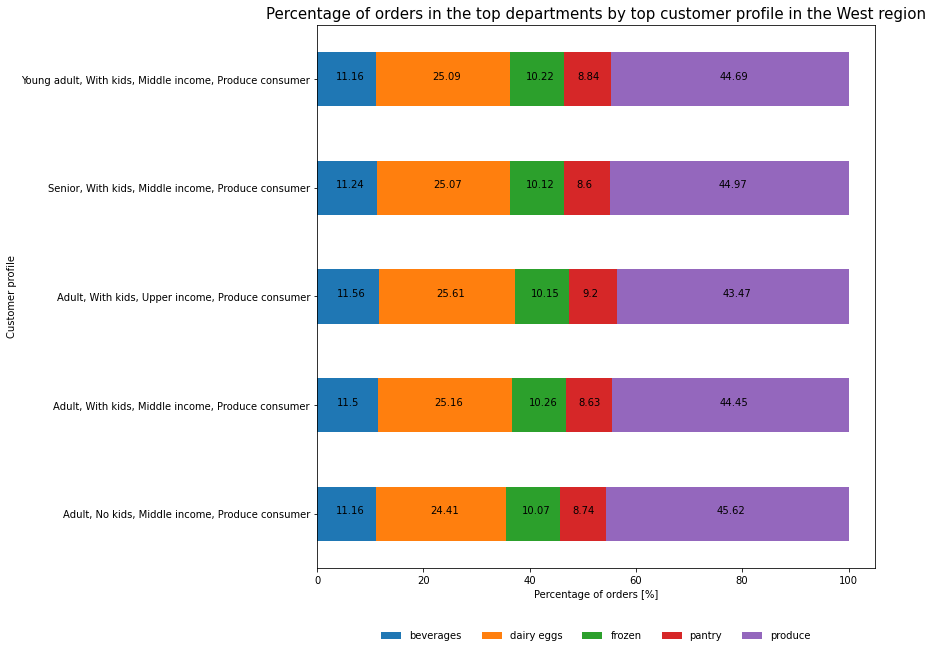

In [6]:
# Plot a stacked bar chart to visualize the number of orders in each of the top 5 departments by top 5 customer profiles

# Create a crosstab between the 'customer_profile' and 'department' columns
profile_department = pd.crosstab(index = df_ords_prods_profile_West['customer_profile'], columns = df_ords_prods_profile_West['department'])

# Keep only the top 5 departments
to_drop_dept = []
for i in list(profile_department.columns):
    if i not in list(top_5_depts['prices'].index):
        to_drop_dept.append(i)

profile_department.drop(to_drop_dept, axis = 1, inplace = True)
profile_department = profile_department.div(profile_department.sum(axis=1), axis=0)*100
        
# Keep only the top 5 profiles
to_drop_profile = []
for i in list(profile_department.index):
    if i not in list(top_5_profiles['customer_spending'].index):
        to_drop_profile.append(i)
        
profile_department.drop(to_drop_profile, axis = 0, inplace = True)

# Create plot
ax = profile_department.plot.barh(stacked=True, figsize=(10, 10))

# Plot label inside each column
y_offset = 0
x_offset = -2
for bar in ax.patches:
    ax.text(bar.get_x() + bar.get_width() / 2 + x_offset, bar.get_height() / 2 + bar.get_y() + y_offset,
            round(bar.get_width(),2))

plt.legend(loc = 'lower center', bbox_to_anchor=(0.5, -0.15), frameon = False, ncol = len(profile_department.columns))
plt.ylabel("Customer profile")
plt.xlabel("Percentage of orders [%]")
plt.title("Percentage of orders in the top departments by top customer profile in the West region", size=15)

# Export chart as image (.png)
plt.savefig(os.path.join(path, '04 Analysis','Visualizations', 'bar_stacked_West_orders_depts_profile.png'))
plt.show()

# 09. Business questions

## I. What are the busiest days of the week and hours of the day in terms of orders?

In [2]:
# Import data from 'orders_products_profiles.pkl' and 'df_customer_profile.pkl'
path = r'C:\Users\lucav\Desktop\Instacart Basket Analysis'
df_ords_prods_profile = pd.read_pickle(os.path.join(path, '02 Data','Prepared Data', 'orders_products_profiles.pkl'))
df_customers = pd.read_pickle(os.path.join(path, '02 Data','Prepared Data', 'df_customer_profile.pkl'))

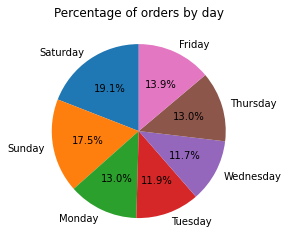

In [3]:
# Plot a pie chart displaying the percentage of orders by day of the week
pie_chart = df_ords_prods_profile.groupby('day_of_week').agg({'order_number': ['count']})
labels = pie_chart.index.to_list()
sizes = pie_chart['order_number']['count']

for index, value in enumerate(labels):
    if value == 0:
        labels[index] = 'Saturday'
    elif value == 1:
        labels[index] = 'Sunday'
    elif value == 2:
        labels[index] = 'Monday'
    elif value == 3:
        labels[index] = 'Tuesday'
    elif value == 4:
        labels[index] = 'Wednesday'
    elif value == 5:
        labels[index] = 'Thursday'
    elif value == 6:
        labels[index] = 'Friday'

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Percentage of orders by day')

plt.savefig(os.path.join(path, '04 Analysis','Visualizations', 'orders_by_day.png'))
plt.show()

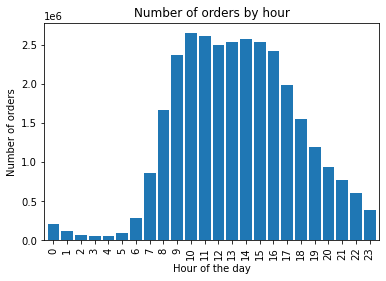

In [33]:
# Plot a bar chart displaying the number of orders by hour of the day

# Create a subplot
fig, ax1 = plt.subplots()

# Plot the bar chart
df_ords_prods_profile['hour_of_day'].value_counts().sort_index().plot.bar(width = 0.85)

# Add axes labels
ax1.set_xlabel('Hour of the day')
ax1.set_ylabel('Number of orders')
plt.title('Number of orders by hour')

# Display plot and save it as image
plt.savefig(os.path.join(path, '04 Analysis','Visualizations', 'orders_by_hour.png'))
plt.show()

## II. When do people spend the most money throughout the day?

In [3]:
# Create a subset by sampling the data based on a 70/30 ratio

# Set the seed to generate a reproducible pattern
np.random.seed(4)

# Store the boolean values in 'dev' list
dev = np.random.rand(len(df_ords_prods_profile)) <= 0.7

# Split 'ords_prods_merge' into two samples
big = df_ords_prods_profile[dev] # The True values in 'dev' are stored in 'big' (70% of the total dataframe)
small = df_ords_prods_profile[~dev] # The False values in 'dev' are stored in 'small' (30% of the total dataframe)

In [4]:
# Create a subset of the 'small' dataframe selecting only 'prices' and 'hour_of_day' columns
df_small = small[['hour_of_day','prices']]

# Rename columns to show proper labels on x and y axes
df_small.rename(columns = {'hour_of_day':'Hour of the day', 'prices':'Amount spent for a order [$]'}, inplace = True)

C:\Users\lucav\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


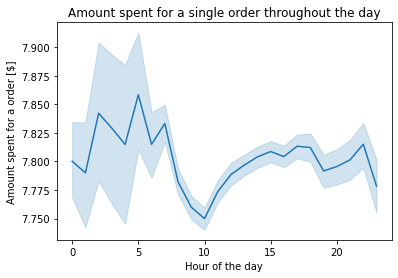

In [5]:
# Create a line chart of 'df_small'
sns.lineplot(data = df_small, x = 'Hour of the day', y = 'Amount spent for a order [$]').set(title="Amount spent for a single order throughout the day")

plt.savefig(os.path.join(path, '04 Analysis','Visualizations', 'price_by_hour.png'))
plt.show()

## III. Create simpler price range groupings

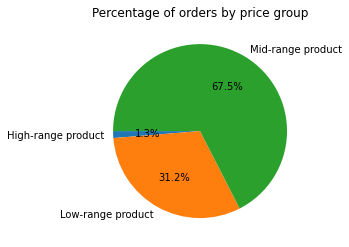

In [7]:
# The groups were created in section 4.7

# Plot a pie chart displaying the percentage of orders by price group
pie_chart = df_ords_prods_profile.groupby('price_range_loc').agg({'order_number': ['count']})
labels = pie_chart.index.to_list()
sizes = pie_chart['order_number']['count']

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=180)
plt.title('Percentage of orders by price group')

plt.savefig(os.path.join(path, '04 Analysis','Visualizations', 'orders_by_group.png'))
plt.show()

## IV. Are there certain types of products that are more popular than others in terms of frequency of orders?

In [12]:
# Compute the total revenue by department
prods_sold_by_dept = df_ords_prods_profile.groupby('department').agg({'order_number': ['sum']}).sort_values(('order_number','sum'), ascending=True)

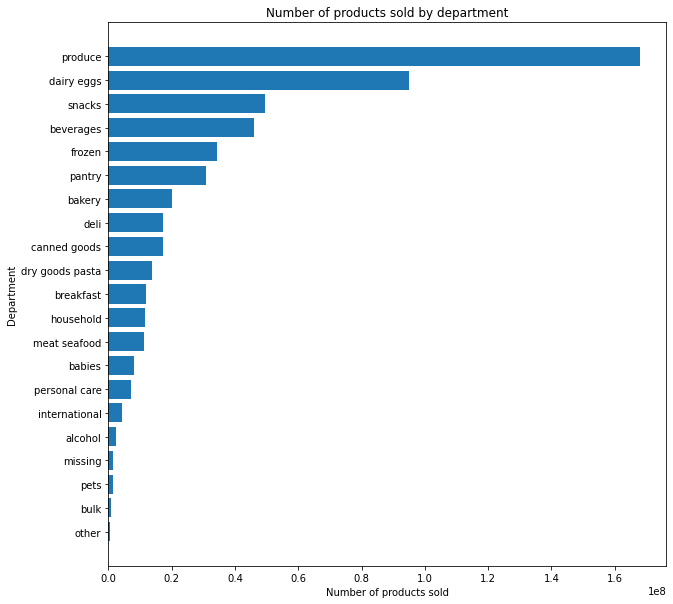

In [13]:
# Plot a bar chart to display the number of products sold by department
y = prods_sold_by_dept['order_number']['sum'].index
x = prods_sold_by_dept['order_number']['sum']

plt.figure(figsize=(10,10))
plt.title('Number of products sold by department')
plt.barh(y, x)
plt.ylabel('Department')
plt.xlabel('Number of products sold')

# Export chart as image (.png)
plt.savefig(os.path.join(path, '04 Analysis','Visualizations', 'products_sold_by_dept.png'))
plt.show()

## V. What’s the distribution among users in regards to their brand loyalty?

In [46]:
# Create a subset containing only the 'user_id' and 'loyalty_flag' columns
user_id_loyalty = df_ords_prods_profile[['user_id', 'loyalty_flag']]

# Remove all the duplicated user ids to have only one entry for each customer
user_id_loyalty = user_id_loyalty.drop_duplicates(subset='user_id')

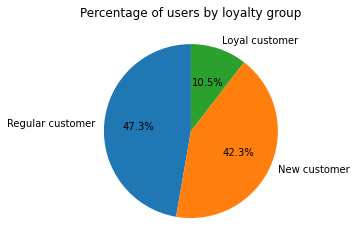

In [47]:
# Plot a pie chart displaying the percentage of users by loyalty group
pie_chart = user_id_loyalty['loyalty_flag'].value_counts()
labels = pie_chart.index.to_list()
sizes = pie_chart.to_list()

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Percentage of users by loyalty group')

plt.savefig(os.path.join(path, '04 Analysis','Visualizations', 'users_by_loyalty.png'))
plt.show()

## VI. Are there differences in ordering habits based on a customer’s loyalty status?

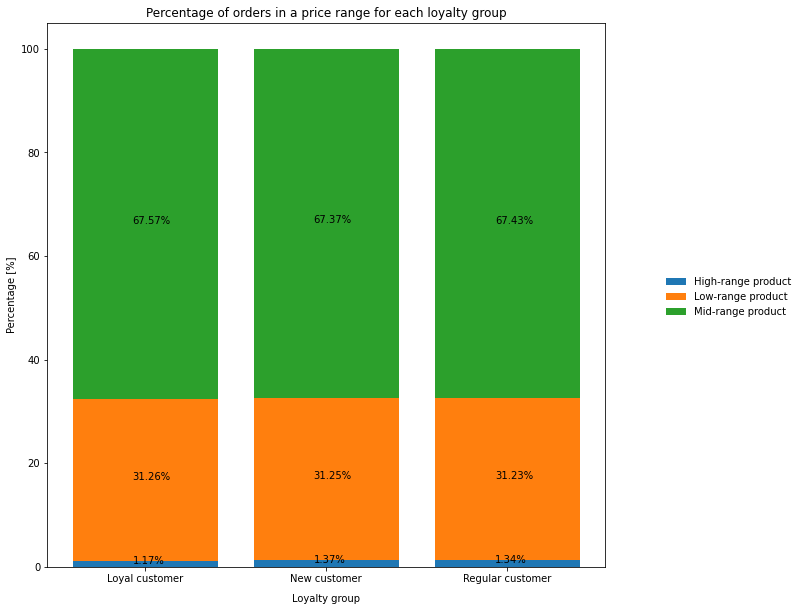

In [13]:
# Plot a stacked bar chart to display the relationship between the percentage of orders in a price range for each loyalty group

# Create a crosstab between the 'loyalty_flag' and 'price_range_loc' columns
loyalty_price_range = pd.crosstab(index = df_ords_prods_profile['loyalty_flag'], 
                                  columns = df_ords_prods_profile['price_range_loc'], normalize="index")

# Create plot
fig, ax = plt.subplots(figsize=(10,10))

# Initialise the bottom of the first set of bars at 0
bottom = np.zeros(len(loyalty_price_range))

# Plot each bar
for i, col in enumerate(loyalty_price_range.columns):
    ax.bar(loyalty_price_range.index, loyalty_price_range[col]*100, bottom=bottom, label=col)
    bottom += np.array(loyalty_price_range[col]*100)

# Plot label inside each column
y_offset = 0
x_offset = -0.07
for bar in ax.patches:
    ax.text(bar.get_x() + bar.get_width() / 2 + x_offset, bar.get_height() / 2 + bar.get_y() + y_offset,
            f'{round(bar.get_height(),2)}%')

plt.legend(bbox_to_anchor = (1.35,0.55), frameon = False)
plt.ylabel("Percentage [%]")
plt.xlabel("Loyalty group")
ax.xaxis.set_label_coords(0.5,-0.05)
plt.title("Percentage of orders in a price range for each loyalty group")

plt.savefig(os.path.join(path, '04 Analysis','Visualizations', 'orders_by_loyalty_&_price.png'))
plt.show()

## VII. Are there differences in ordering habits based on a customer’s region?

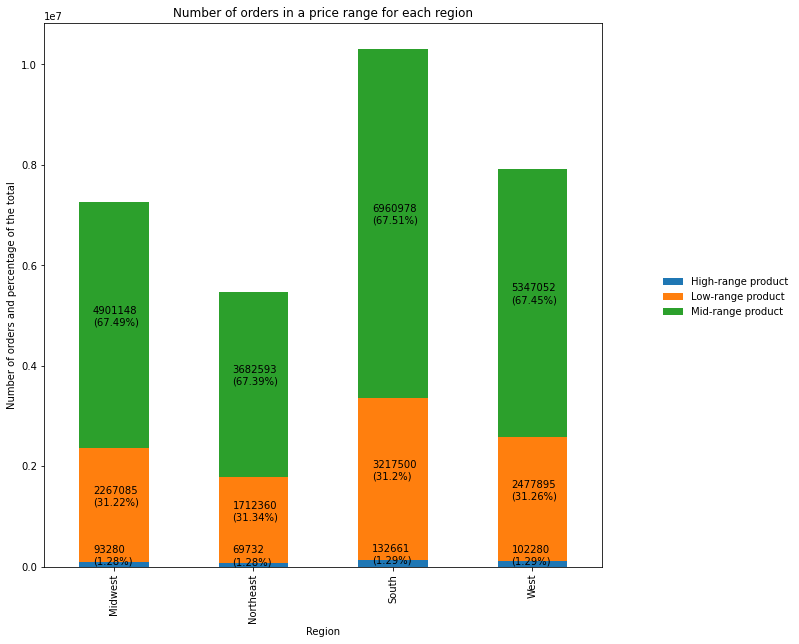

In [4]:
# Plot a stacked bar chart to display the relationship between the number of orders in a price range for each region

# Create crosstabs between the 'region' and 'price_range_loc' columns
region_price_range = pd.crosstab(index = df_ords_prods_profile['region'], 
                                 columns = df_ords_prods_profile['price_range_loc'])
region_price_prop = pd.crosstab(index = df_ords_prods_profile['region'], 
                                 columns = df_ords_prods_profile['price_range_loc'], normalize="index")

# Create plot
region_price_range.plot(kind='bar', stacked=True, figsize=(10, 10))

# Plot label inside each column
y_offset = 0
x_offset = -0.15
for n, x in enumerate([*region_price_prop.index.values]):
    for (count, proportion, y_loc) in zip(region_price_range.loc[x], region_price_prop.loc[x], region_price_range.loc[x].cumsum()):
        plt.text(x=n + x_offset, y=(y_loc - count) + (count / 2) + y_offset, s=f'{count}\n({np.round(proportion * 100, 2)}%)')

plt.legend(bbox_to_anchor = (1.35,0.55), frameon = False)
plt.ylabel("Number of orders and percentage of the total")
plt.xlabel("Region")
plt.title("Number of orders in a price range for each region")

plt.savefig(os.path.join(path, '04 Analysis','Visualizations', 'orders_by_region_&_price.png'))
plt.show()

## VIII. Is there a connection between age and family status in terms of ordering habits?

In [3]:
# Create the 'age_range' column based on the ranges specified above
df_ords_prods_profile.loc[(df_ords_prods_profile['age'] >= 18) & (df_ords_prods_profile['age'] <= 34), 'age_range'] = 'Young adult'
df_ords_prods_profile.loc[(df_ords_prods_profile['age'] >= 35) & (df_ords_prods_profile['age'] <= 64), 'age_range'] = 'Adult'
df_ords_prods_profile.loc[df_ords_prods_profile['age'] >= 65, 'age_range'] = 'Senior'

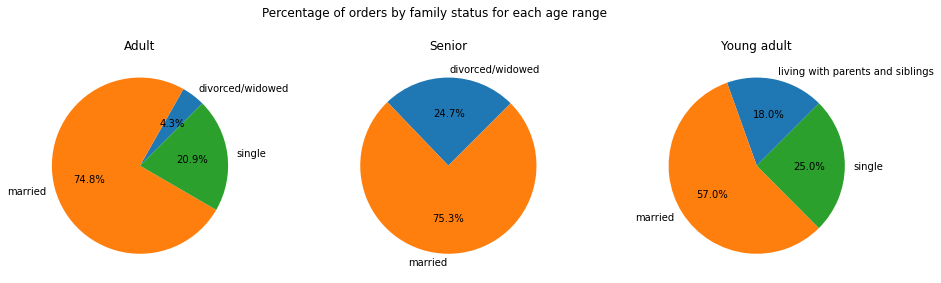

In [95]:
# Plot a pie chart for each age range displaying the percentage of orders by family status group

pie_chart = pd.crosstab(index = df_ords_prods_profile['age_range'], columns = df_ords_prods_profile['fam_status'])
fig, axes = plt.subplots(1, 3, figsize=(15, 15))

for index, value in enumerate(pie_chart.index):
    labels = []
    sizes = []
    for i in range(0, len(pie_chart.values[index])):
        if pie_chart.values[index][i] != 0:
            title = pie_chart.index[index]
            labels.append(pie_chart.columns[i])
            sizes.append(pie_chart.values[index][i])

    axes[index].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=45)
    axes[index].set_title(title)

fig.subplots_adjust(wspace=.4)
plt.suptitle('Percentage of orders by family status for each age range', y=.65)
plt.savefig(os.path.join(path, '04 Analysis','Visualizations', 'orders_by_fam_status_&_age.png'))
plt.show()

## IX. What different classifications does the demographic information suggest?

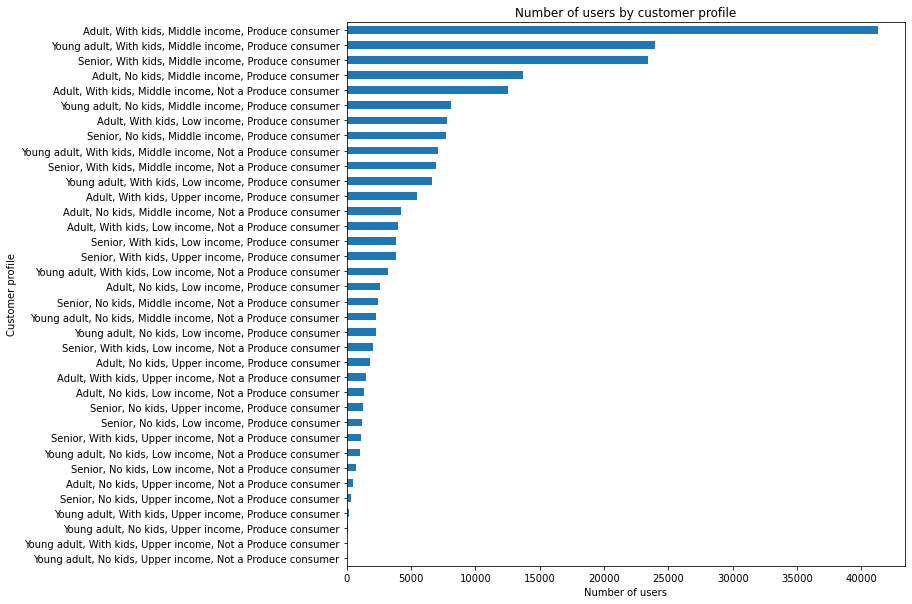

In [3]:
# Plot a bar chart to display the number of users for each customer profile
plt.figure(figsize=(10,10))
plt.title('Number of users by customer profile')
df_customers['customer_profile'].value_counts().sort_values().plot.barh()
plt.ylabel('Customer profile')
plt.xlabel('Number of users')

# Export chart as image (.png)
plt.savefig(os.path.join(path, '04 Analysis','Visualizations', 'bar_users_profiles.png'))
plt.show()

## X. What differences can you find in ordering habits of different customer profiles?

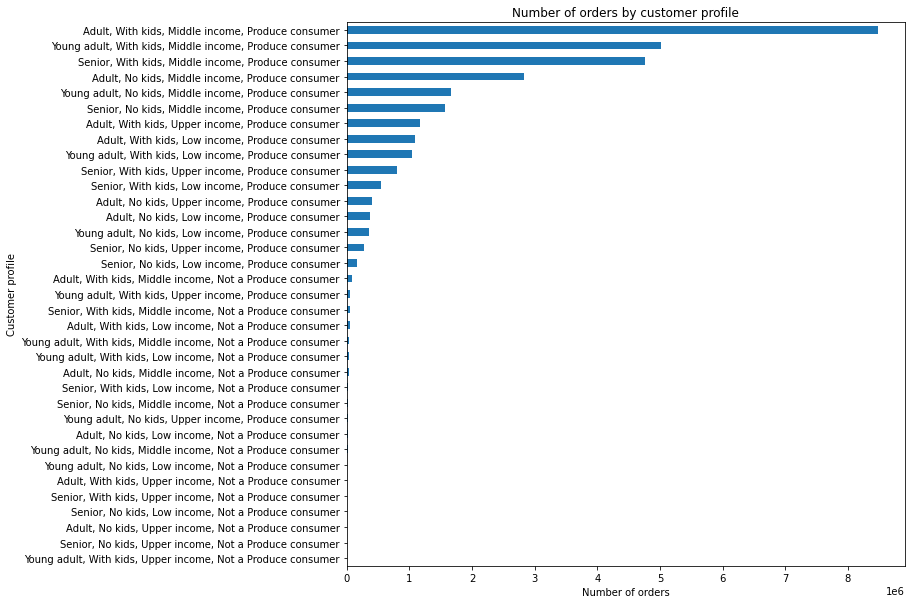

In [4]:
# Plot a bar chart to display the number of orders placed by each customer profile
plt.figure(figsize=(10,10))
plt.title('Number of orders by customer profile')
df_ords_prods_profile['customer_profile'].value_counts().sort_values().plot.barh()
plt.ylabel('Customer profile')
plt.xlabel('Number of orders')

# Export chart as image (.png)
plt.savefig(os.path.join(path, '04 Analysis','Visualizations', 'bar_orders_profiles.png'))
plt.show()